# `torch.nn` 是什么？

PyTorch 提供了设计优雅的模块和类 [torch.nn](https://pytorch.org/docs/stable/nn.html)、[torch.optim](https://pytorch.org/docs/stable/optim.html)、[Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) 和 [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)，帮助您创建和训练神经网络。为了充分利用它们的强大功能并针对您的问题对其进行定制，您需要真正了解它们在做什么。为了加深这种理解，我们将首先在 MNIST 数据集上训练基本神经网络，但不使用这些模型的任何特征；我们最初将只使用最基本的 PyTorch 张量功能。然后，我们将每次从 `torch.nn`、`torch.optim`、`Dataset` 或 `DataLoader` 中逐步添加一个特征，展示每个特征的确切作用，以及如何使代码更简洁或更灵活。

本教程假定您已经安装了 PyTorch，并且熟悉张量操作的基础知识。(如果你熟悉 Numpy 数组操作，你会发现这里使用的 PyTorch 张量运算几乎相同)。

## MINIST 数据集

我们将使用经典的 [MNIST](https://yann.lecun.com/exdb/mnist/index.html) 数据集，它由手绘数字（0 到 9 之间）的黑白图像组成。我们将使用 [pathlib](https://docs.python.org/3/library/pathlib.html) 处理路径（Python 3 标准库的一部分），并使用请求下载数据集。我们只会在使用模块时才导入它们，这样你就能清楚地看到每一点都用到了什么。

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

该数据集采用 numpy 数组格式，并使用 Python 专用的数据序列化格式 pickle 进行存储。

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

每幅图像的大小为 28 x 28，以长度为 784（=28x28）的扁平行存储。 让我们来看看其中一幅；我们需要先将其重塑为 2d 格式。

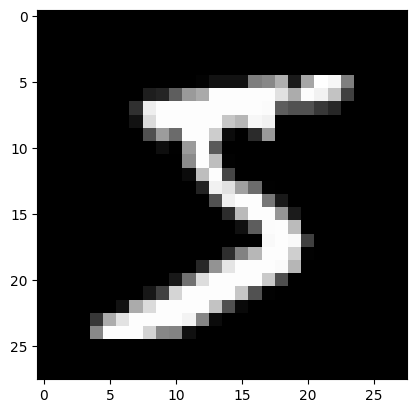

(50000, 784)


In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

PyTorch 使用 `torch.tensor`，而不是 numpy 数组，因此我们需要转换数据。

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## 从零开始神经网络(不使用 `torch.nn`)

让我们先用 PyTorch 张量运算创建一个模型。我们假设你已经熟悉了神经网络的基础知识（如果还不熟悉，可以在 [course.fast.ai](https://course.fast.ai/) 上学习）。 

PyTorch 提供了创建随机或零填充张量的方法，我们将用它们来创建简单线性模型的权重和偏置。这些只是普通的张量，但有一个非常特殊的附加条件：我们告诉 PyTorch 它们需要梯度。这将导致 PyTorch 记录对张量进行的所有操作，这样它就能在反向传播过程中自动计算梯度！

对于权重，我们在初始化后设置 `requires_grad`，因为我们不希望梯度中包含这一步。(注意，在 PyTorch 中，尾部的 `_` 表示操作是就地执行的)。

> 在这里，我们使用 [Xavier 初始化法](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)对权重进行初始化（乘以 `1/sqrt(n)`）。

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

由于 PyTorch 能够自动计算梯度，我们可以使用任何标准 Python 函数（或可调用对象）作为模型！因此，我们只需编写一个普通的矩阵乘法和广播加法，就能创建一个简单的线性模型。我们还需要一个激活函数，所以我们要写 `log_softmax` 并使用它。记住：尽管 PyTorch 提供了大量预写的损失函数、激活函数等，但你也可以用普通的 python 语言轻松地编写自己的函数。PyTorch 甚至会自动为你的函数创建快速加速器或矢量化 CPU 代码。

In [8]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

上面的 `@` 代表矩阵乘法运算。我们将对一批数据（在本例中为 64 张图像）调用我们的函数。这是一次前向传递。请注意，由于我们从随机权重开始，因此在此阶段我们的预测不会比随机更好。

In [9]:
bs = 64 # batch size

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.3920, -1.7709, -2.3689, -3.3666, -1.7342, -2.7798, -2.3285, -2.3049,
        -2.6502, -2.2650], grad_fn=<SelectBackward0>) torch.Size([64, 10])


如您所见，`preds` 张量不仅包含张量值，还包含梯度函数。我们稍后会使用它来进行反向传播。

让我们实现负对数似然作为损失函数（同样，我们可以只使用标准 Python）：

In [10]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

让我们用随机模型检查一下我们的损失，这样我们就可以看看在稍后的反向传播之后我们是否会有所改进。

In [11]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4232, grad_fn=<NegBackward0>)


我们还来实现一个函数来计算模型的准确率。对于每个预测，如果具有最大值的索引与目标值匹配，则预测是正确的。

In [12]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

让我们检查一下随机模型的准确性，这样我们就可以看看我们的准确性是否会随着损失的改善而提高。

In [13]:
print(accuracy(preds, yb))

tensor(0.0625)


现在我们可以运行训练循环。对于每次迭代，我们将：
+ 选择一小批数据（大小为 `bs`）
+ 使用模型进行预测
+ 计算损失
+ `loss.backward()` 更新模型的梯度，在本例中为权重和偏差。

我们现在使用这些梯度来更新权重和偏差。我们在 `torch.no_grad()` 上下文管理器中执行此操作，因为我们不希望在下一次梯度计算中记录这些操作。您可以在[此处](https://pytorch.org/docs/stable/notes/autograd.html)阅读有关 PyTorch 的 Autograd 如何记录操作的更多信息。

然后我们将梯度设置为零，以便为下一个循环做好准备。否则，我们的梯度将记录已发生的所有操作的运行总数（即 `loss.backward()` 将梯度添加到已存储的内容中，而不是替换它们）。

> 您可以使用标准 Python 调试器逐步执行 PyTorch 代码，从而检查每一步的各种变量值。取消注释下面的 `set_trace()` 以尝试一下。

In [15]:
from IPython.core.debugger import set_trace

lr = 0.5    # 学习率
epochs = 2  # 训练的多少次

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

就是这样：我们已经从头开始创建并训练了一个最小神经网络（在本例中为逻辑回归，因为我们没有隐藏层）！

让我们检查一下损失和准确率，并将它们与之前的结果进行比较。我们预计损失会减少，准确率会提高，结果确实如此。

In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NegBackward0>) tensor(1.)


## 使用 `torch.nn.functional`

我们现在将重构代码，使其与之前的功能相同，只是我们将开始利用 PyTorch 的 `nn` 类使其更简洁、更灵活。从这里开始的每一步，我们都应该使代码更短、更易理解和/或更灵活。

第一步也是最简单的一步是通过将手写的激活和损失函数替换为来自 `torch.nn.functional`（通常按照惯例导入到命名空间 `F`）的函数来缩短代码。此模块包含 `torch.nn` 库中的所有函数（而库的其他部分包含类）。除了各种损失和激活函数外，您还可以在这里找到一些用于创建神经网络的便捷函数，例如池化函数。（还有一些函数用于执行卷积、线性层等，但正如我们所见，通常最好使用库的其他部分来处理这些函数。）

如果您使用负对数似然损失和对数 softmax 激活，那么 Pytorch 提供了一个将两者结合起来的单一函数 `F.cross_entropy`。因此，我们甚至可以从模型中删除激活函数。

In [17]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

请注意，我们不再在模型函数中调用 `log_softmax`。让我们确认我们的损失和准确率与之前相同：

In [18]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NllLossBackward0>) tensor(1.)


## 使用 `nn.Module` 调整

接下来，我们将使用 `nn.Module` 和 `nn.Parameter`，以获得更清晰、更简洁的训练循环。我们将 `nn.Module` 子类化（它本身是一个类，能够跟踪状态）。在本例中，我们想要创建一个类来保存我们的权重、偏差和前向步骤的方法。`nn.Module` 有许多我们将要使用的属性和方法（例如 `.parameters()` 和 `.zero_grad()`）。

> `nn.Module`（大写 `M`）是 PyTorch 特有的概念，也是我们会经常使用的类。`nn.Module` 不要与 Python 的模块（小写 m）概念混淆，后者是可以导入的 Python 代码文件。

In [19]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

由于我们现在使用对象而不是仅仅使用函数，因此我们首先必须实例化我们的模型：

In [20]:
model = Mnist_Logistic()

现在我们可以用和之前一样的方式计算损失。请注意，`nn.Module` 对象的使用方式就像它们是函数一样（即它们是可调用的），但在后台，Pytorch 会自动调用我们的 `forward` 方法。

In [21]:
print(loss_func(model(xb), yb))

tensor(2.2907, grad_fn=<NllLossBackward0>)


以前，对于我们的训练循环，我们必须按名称更新每个参数的值，并分别手动将每个参数的梯度归零，如下所示：

In [ ]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

现在我们可以利用 `model.parameters()` 和 `model.zero_grad()`（它们都是由 PyTorch 为 `nn.Module` 定义的）来使这些步骤更加简洁，并且不容易出现忘记某些参数的错误，特别是如果我们有一个更复杂的模型：

In [ ]:
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
        model.zero_grad()

我们将把我们的小训练循环包装在一个适合的函数中，以便我们稍后可以再次运行它。

In [24]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss =loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

让我们再检查一下损失是否减少了：

In [25]:
print(loss_func(model(xb), yb))

tensor(0.0807, grad_fn=<NllLossBackward0>)


## 使用 `nn.Linear` 调整

我们继续重构代码。我们不再手动定义和初始化 `self.weights` 和 `self.bias`，也不再计算 `xb @ self.weights + self.bias`，而是使用 Pytorch 类 `nn.Linear` 作为线性层，它为我们完成了所有这些工作。Pytorch 有许多类型的预定义层，可以大大简化我们的代码，而且通常还可以加快速度。

In [26]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

我们实例化我们的模型并以与之前相同的方式计算损失：

In [27]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2920, grad_fn=<NllLossBackward0>)


我们仍然可以使用与以前相同的适应方法。

In [28]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0818, grad_fn=<NllLossBackward0>)


## 使用 `torch.optim` 进行调整

Pytorch 还有一个包含各种优化算法的包，`torch.optim`。我们可以使用优化器中的 `step` 方法来向前迈出一步，而不是手动更新每个参数。

这将让我们取代之前手动编码的优化步骤：

In [ ]:
with torch.no_grad():
    for p in model.parameters(): 
        p -= p.grad * lr
    model.zero_grad()

而只需使用：

In [ ]:
opt.step()
opt.zero_grad()

（`optim.zero_grad()` 将梯度重置为 0，我们需要在计算下一个小批量的梯度之前调用它。）

In [29]:
from torch import optim

我们将定义一个小函数来创建我们的模型和优化器，以便我们将来可以重复使用它。

In [30]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3390, grad_fn=<NllLossBackward0>)
tensor(0.0825, grad_fn=<NllLossBackward0>)


## 使用 `Dataset` 调整

PyTorch 有一个抽象的 `Dataset` 类。`Dataset` 可以是任何具有 `__len__` 函数（由 Python 的标准 `len` 函数调用）和 `__getitem__` 函数作为索引方式的东西。本教程介绍了一个很好的示例，介绍如何创建自定义 `FacialLandmarkDataset` 类作为 `Dataset` 的子类。

PyTorch 的 `TensorDataset` 是一个包装张量的 `Dataset`。通过定义长度和索引方式，这也为我们提供了一种沿张量的第一维进行迭代、索引和切片的方法。这将使我们在训练时更容易在同一行中访问独立变量和因变量。

In [31]:
from torch.utils.data import TensorDataset

`x_train` 和 `y_train` 都可以组合在一个 `TensorDataset` 中，这样更容易进行迭代和切片。

In [32]:
train_ds = TensorDataset(x_train, y_train)

以前，我们必须分别迭代 `x` 和 `y` 值的小批量：

In [ ]:
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

现在，我们可以一起完成这两个步骤：

In [33]:
xb,yb = train_ds[i*bs : i*bs+bs]

In [34]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0816, grad_fn=<NllLossBackward0>)


## 使用 `DataLoader` 进行调整

PyTorch 的 `DataLoader` 负责管理批次。您可以从任何数据集创建 `DataLoader`。`DataLoader` 使迭代批次变得更容易。无需使用 `train_ds[i*bs : i*bs+bs]`，`DataLoader` 会自动为我们提供每个小批次。

In [35]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

以前，我们的循环像这样迭代批次 `(xb, yb)`：

In [ ]:
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)

现在，我们的循环更加清晰，因为 `(xb, yb)` 是从数据加载器自动加载的：

In [ ]:
for xb,yb in train_dl:
    pred = model(xb)

In [36]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward0>)


得益于 PyTorch 的 `nn.Module`、`nn.Parameter`、`Dataset` 和 `DataLoader`，我们的训练循环现在显著缩小，并且更易于理解。现在让我们尝试添加在实践中创建有效模型所需的基本功能。

## 添加验证

在第 1 部分中，我们只是尝试设置一个合理的训练循环以用于我们的训练数据。实际上，您始终应该有一个验证集，以便确定是否过度拟合。

打乱训练数据对于防止批次之间的相关性和过度拟合非常重要。另一方面，无论我们是否打乱验证集，验证损失都将相同。由于打乱需要额外的时间，因此打乱验证数据是没有意义的。

我们将使用比训练集大两倍的验证集批次大小。这是因为验证集不需要反向传播，因此占用的内存更少（它不需要存储梯度）。我们利用这一点来使用更大的批次大小并更快地计算损失。

In [38]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

我们将在每个时期结束时计算并打印验证损失。

请注意，我们总是在训练之前调用 `model.train()`，在推理之前调用 `model.eval()`，因为这些被 `nn.BatchNorm2d` 和 `nn.Dropout` 等层使用，以确保这些不同阶段的适当行为。

In [39]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3798)
1 tensor(0.3623)


## 创建 `fit()` 和 `get_data()`

现在，我们将进行一些重构。由于我们经历了两次类似的过程来计算训练集和验证集的损失，因此我们将其变成自己的函数 `loss_batch`，该函数计算一个批次的损失。

我们为训练集传递一个优化器，并使用它来执行反向传播。对于验证集，我们没有传递优化器，因此该方法不执行反向传播。

In [52]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

`fit` 运行必要的操作来训练我们的模型并计算每个时期的训练和验证损失。

In [59]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xxb, yyb) for xxb, yyb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

`get_data` 返回训练和验证集的数据加载器。

In [60]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

现在，我们获取数据加载器和拟合模型的整个过程可以用 3 行代码运行：

In [61]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.337063308095932
1 0.30764186199903487


您可以使用这 3 行基本代码来训练各种模型。让我们看看我们是否可以用它们来训练卷积神经网络 (CNN)！

## 从规约切换到 CNN

我们现在要构建具有三个卷积层的神经网络。由于上一节中的任何函数都没有假设模型形式，因此我们将能够使用它们来训练 CNN，而无需进行任何修改。

我们将使用 PyTorch 的预定义 [`Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) 类作为我们的卷积层。我们定义一个具有 3 个卷积层的 CNN。每个卷积后跟一个 `ReLU`。最后，我们执行平均池化。（请注意，视图是 PyTorch 版本的 `Numpy` 重塑）

In [63]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    
lr = 0.1

[动量](https://cs231n.github.io/neural-networks-3/#sgd)是随机梯度下降的一种变体，它也会考虑之前的更新，并且通常可以加快训练速度。

In [64]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3507611538887024
1 0.2738780374407768


## 使用 `nn.Sequential`

`torch.nn` 还有另一个方便的类，我们可以使用它来简化我们的代码：`Sequential`。`Sequential` 对象以顺序方式运行其中包含的每个模块。这是编写神经网络的一种更简单的方法。

要利用这一点，我们需要能够轻松地从给定函数定义自定义层。例如，PyTorch 没有视图层，我们需要为我们的网络创建一个。`Lambda` 将创建一个层，然后我们可以在使用 `Sequential` 定义网络时使用它。

In [65]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

使用 `Sequential` 创建的模型很简单：

In [68]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36834475183486937
1 0.24591302394866943


## 使用 `DataLoader`

我们的 CNN 相当简洁，但它只适用于 MNIST，因为：
+ 它假设输入是一个 28*28 长的向量
+ 它假设最终的 CNN 网格大小为 4*4（因为这是我们使用的平均池化内核大小）

让我们摆脱这两个假设，这样我们的模型就可以适用于任何 2d 单通道图像。首先，我们可以通过将数据预处理移到生成器中来删除初始 Lambda 层：

In [69]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

接下来，我们可以用 `nn.AdaptiveAvgPool2d` 替换 `nn.AvgPool2d`，这使我们能够定义所需的输出张量的大小，而不是我们拥有的输入张量。因此，我们的模型将适用于任何大小的输入。

In [70]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

让我们尝试一下：

In [71]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3435923916339874
1 0.2430037283539772


## 使用加速器

如果你足够幸运，可以使用 CUDA 等加速器（你可以从大多数云提供商那里以每小时 0.50 美元的价格租用一个），你可以使用它来加速你的代码。首先检查你的加速器是否在 Pytorch 中运行：

In [73]:
# If the current accelerator is available, we will use it. Otherwise, we use the CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


让我们更新预处理以将批次移动到加速器：

In [74]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(device), y.to(device)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

最后，我们可以将我们的模型移到加速器上。

In [75]:
model.to(device)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

你会发现它现在运行得更快了：

In [76]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.19766159852743148
1 0.17768677291870116


## 结束语

我们现在有一个通用的数据管道和训练循环，您可以使用它们通过 Pytorch 训练多种类型的模型。要了解现在训练模型有多简单，请查看 [mnist_sample 笔记本](https://github.com/fastai/fastai_dev/blob/master/dev_nb/mnist_sample.ipynb)。

当然，您还需要添加许多内容，例如**数据增强**、**超参数调整**、**监控训练**、**迁移学习**等等。这些功能在 fastai 库中可用，该库使用本教程中所示的相同设计方法开发，为希望进一步发展其模型的从业者提供了自然的下一步。

我们在本教程开始时承诺，我们将通过示例解释 `torch.nn`、`torch.optim`、`Dataset` 和 `DataLoader` 中的每一个。那么让我们总结一下我们所看到的内容：

+ `torch.nn`:
  - `Module`：创建一个可调用函数，其行为类似于函数，但也可以包含状态（例如神经网络层权重）。它知道它包含哪些参数，并且可以将所有梯度归零，循环遍历它们以更新权重等。
  - `Parameter`：张量的包装器(Wrapper)，它告诉 `Module` 它具有在反向传播期间需要更新的权重。只有设置了`requires_grad=True`属性的张量才会更新
  - `function`：一个模块（通常按照惯例导入到`F`命名空间），其中包含**激活函数**、**损失函数**等，以及**卷积层**和**线性层**等非状态版本的层
+ `torch.optim`：包含优化器（例如`SGD`），它们在反向步骤期间更新参数的权重
+ `Dataset`：具有`__len__`和`__getitem__`的对象的抽象接口，包括 Pytorch 提供的类，例如`TensorDataset`
+ `DataLoader`：获取任何数据集并创建一个返回批量数据的**迭代器**